### DataParallel

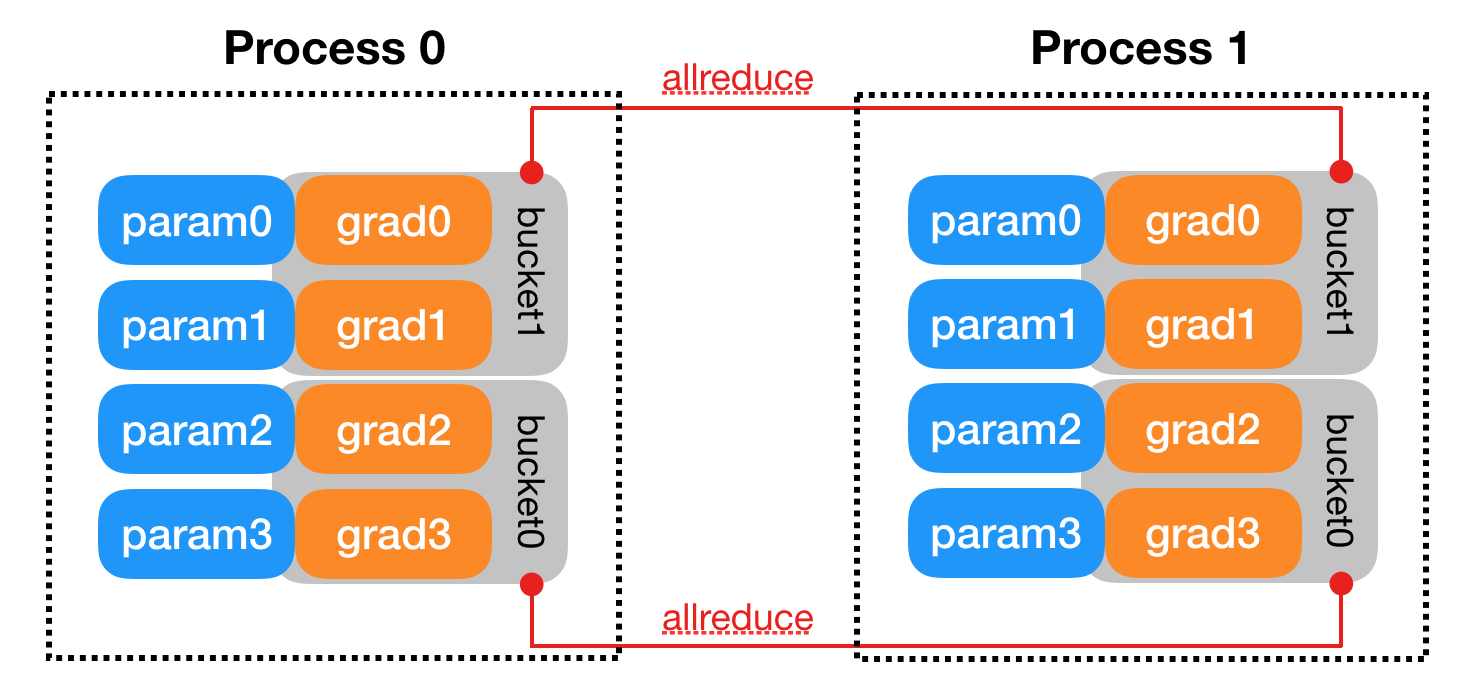

In [ ]:
mean = _get_gradients_mean()
degree = _get_device_num()
grad_reducer = nn.DistributedGradReducer(optimizer.parameters, mean, degree)

def train_step(input_ids, input_mask, masked_lm_ids, masked_lm_positions, masked_lm_weights, \
               next_sentence_label, segment_ids):
    status = init_register()
    input_ids = ops.depend(input_ids, status)
    (total_loss, masked_lm_loss, next_sentence_loss), grads = grad_fn(input_ids, input_mask, segment_ids, \
                          masked_lm_ids, masked_lm_positions, masked_lm_weights, next_sentence_label)
    grads = clip_by_global_norm(grads, clip_norm=1.0)
    grads = grad_reducer(grads)
    status = all_finite(grads, status)
    if status:
        total_loss = loss_scaler.unscale(total_loss)
        grads = loss_scaler.unscale(grads)
        total_loss = ops.depend(total_loss, optimizer(grads))
    total_loss = ops.depend(total_loss, loss_scaler.adjust(status))
    return total_loss, masked_lm_loss, next_sentence_loss, status